In [1]:
import sys
sys.path.append("..")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

In [5]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import torch
from grins.config import EXTERNAL_DATA_DIR
from PIL import Image
import pandas as pd

In [3]:
MIT_PLACE_PULSE_DIR = EXTERNAL_DATA_DIR / "mit-place-pulse"
IMAGES_DIR = MIT_PLACE_PULSE_DIR / "gsv" / "final_photo_dataset"

In [4]:
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct-AWQ", torch_dtype=torch.float16, device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct-AWQ",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct-AWQ", min_pixels=min_pixels, max_pixels=max_pixels)

/home/nicola/Development/GRINS/.venv/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)
Loading checkpoint shards: 100%|██████████| 2/2 [00:40<00:00, 20.46s/it]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint wa

In [6]:
df = pd.read_csv(MIT_PLACE_PULSE_DIR / "votes_clean.csv")
df

,Unnamed: 0,place_id_left,place_id_right,study_id,left,right,voter_uniqueid,choice,study_question,place_name_right,place_name_left,day,time,long_right,lat_right,long_left,lat_left
0,1,50e5e9c1d7c3df413b000000,50f38e44fdc9f065f0000855,50f62cb7a84ea7c5fdd2e458,513d573bfdc9f03587003120,50f5eb3ffdc9f065f00080f7,7681bc0ade864091a957524067c9254f,left,wealthier,Rio De Janeiro,Amsterdam,2014-04-20,21:17:31,-22.779996,-43.403705,52.382016,4.861142
1,2,50e5e9c1d7c3df413b000000,50f39092fdc9f065f000097d,5217c351ad93a7d3e7b07a64,513d57f9fdc9f0358700326b,50f5e700fdc9f065f0006ef0,e5939a746d544ce09c04d6453a5a1a3a,left,more beautiful,Sao Paulo,Amsterdam,2013-09-01,03:22:19,-23.638028,-46.601966,52.325979,4.880425
2,3,50e5e9c1d7c3df413b000000,50e734e9d7c3df413b000ebf,50f62c41a84ea7c5fdd2e454,513d57e5fdc9f03587003244,513d7b54fdc9f03587006b19,32c3fe6369814f398dee39f3a68daa4f,right,livelier,Atlanta,Amsterdam,2017-10-02,01:40:35,33.895489,-84.282779,52.358512,4.943212
3,4,50e5e9c1d7c3df413b000000,50f39436fdc9f065f0000acc,50f62ccfa84ea7c5fdd2e459,513d57bdfdc9f035870031fd,50f562e3fdc9f065f0005b45,90dc7520a28f4c58a090d14ec58cb181,equal,more depressing,Singapore,Amsterdam,2013-12-29,16:34:34,1.343338,103.961166,52.332149,4.861824
4,5,50e5e9c1d7c3df413b000000,50f38aaefdc9f065f0000562,50f62c41a84ea7c5fdd2e454,513d56fefdc9f035870030ad,50f61675beb2fed9100008bb,b06240448e62439194a30171f2d84091,right,livelier,Philadelphia,Amsterdam,2016-05-03,13:20:42,40.022366,-75.143560,52.308278,4.977296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565718,1565719,50f39a95fdc9f065f0000e96,50e5f30fd7c3df413b000303,50a68a51fdc9f05596000002,50f42baefdc9f065f00015bb,513cc818fdc9f03587001ae1,1112d0825c9744ee93769263233bd56b,left,safer,Chicago,Warsaw,2014-10-20,22:44:43,41.834481,-87.688391,52.282875,20.969501
1565719,1565720,50f39a95fdc9f065f0000e96,50f386b1fdc9f065f00002c8,50a68a51fdc9f05596000002,50f42c1afdc9f065f000189f,5141477efdc9f04926006a79,0b52c85652bc46b2a20c61123423c9d1,right,safer,Minneapolis,Warsaw,2015-11-06,08:05:17,44.980937,-93.218599,52.183485,20.968599
1565720,1565721,50f39a95fdc9f065f0000e96,50e745a4d7c3df413b00127a,5217c351ad93a7d3e7b07a64,50f42c09fdc9f065f000175c,513cc16cfdc9f0358700148f,7681bc0ade864091a957524067c9254f,left,more beautiful,Cape Town,Warsaw,2014-04-21,15:07:38,-34.031569,18.483364,52.302787,20.937941
1565721,1565722,50f39a95fdc9f065f0000e96,50e734e9d7c3df413b000ebf,50f62ccfa84ea7c5fdd2e459,50f42c09fdc9f065f0001749,513d9b8afdc9f03587007a42,80696b5da0414a25b511ad8c3e038007,left,more depressing,Atlanta,Warsaw,2014-04-07,19:31:51,33.860081,-84.464506,52.287312,21.083399


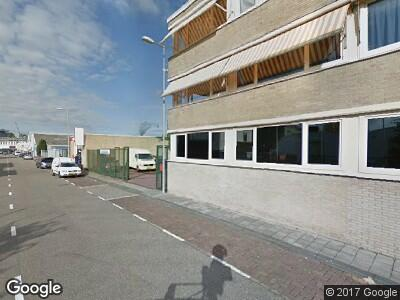

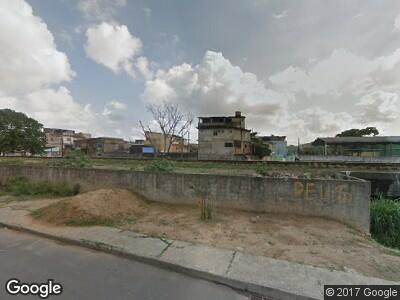

In [10]:
image1 = Image.open(IMAGES_DIR / f"{df.iloc[0]['left']}.jpg").convert("RGB")
image2 = Image.open(IMAGES_DIR / f"{df.iloc[0]['right']}.jpg").convert("RGB")
display(image1)
display(image2)

In [11]:
choice = df.iloc[0]['choice']
study_question = df.iloc[0]['study_question']
winner = "Image 1" if choice == "left" else "Image 2"

In [14]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "Image 1\n"
            },
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "\nImage 2\n"
            },
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"The place in {winner} is perceived as {study_question} compared to the place in the other image. Explain why.",
            }
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    images=[image1, image2],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [15]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The perception of wealthiness in Image 1 can be inferred from several visual cues:\n\n1. **Building Architecture**: The building in Image 1 appears modern and well-maintained, with large windows that suggest a focus on aesthetics and functionality, which are often associated with wealthier areas.\n\n2. **Street Condition**: The street looks clean and orderly, with no visible signs of disrepair or neglect, which might indicate a higher level of maintenance and investment in infrastructure.\n\n3. **Vehicles**: There are parked cars, including what seems to be a van, which could imply a business presence or a higher socioeconomic status among the residents.\n\nIn contrast, Image 2 shows a more run-down area with:\n\n1. **Buildings**: The buildings appear old and possibly in need of repair, which may suggest a lower socioeconomic status.\n\n2. **Vegetation**: The presence of overgrown vegetation and graffiti indicates a lack of regular upkeep, which could be indicative of a less affluent